# Homework 10 - CIFAR10 Image Classification with PyTorch

## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service.   Colab is recommended since it will be setup correctly and will have access to GPU resources.
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`
​
Check that PyTorch installed correctly by running the following:

In [1]:
import torch
torch.rand(5, 3)

tensor([[0.9958, 0.9572, 0.7579],
        [0.6061, 0.3698, 0.0266],
        [0.3498, 0.0755, 0.3379],
        [0.7357, 0.7874, 0.4365],
        [0.8793, 0.5149, 0.4847]])

## Part 0 Imports and Basic Setup  (5 Points)

First, import the required libraries as follows. The libraries we will use will be the same as those in HW8. 

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

**GPU Support**

Training of large network can take a long time. PyTorch supports GPU with just a small amount of effort.

When creating our networks, we will call 
`net.to(device)` to tell the network to train on the GPU, if one is available.  Note, if the network utilizes the GPU, it is important that any tensors we use with it (such as the data) also reside on the CPU.  Thus, a call like `images = images.to(device)` is necessary with any data we want to use with the GPU.

Note: If you can't get access to a GPU, don't worry to much.  Since we use very small networks, the difference between CPU and GPU isn't large and in some cases GPU will actually be slower.

In [3]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Code

In [0]:
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)

best_acc = 0
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=100, start_epoch=0, enable_saving=False):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  best_acc = 0
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(start_epoch, start_epoch + num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
    
     # Save checkpoint.
    acc = validation_acc
    if acc > best_acc:
      print('Prev accuracy: %3f ; Current accuracy: %3f' %(best_acc, acc))
    if enable_saving and acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': i,
        }
        torch.save(state, './ckpt.t7')
        best_acc = acc
        
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [0]:
!mkdir hw10_data

In [6]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='hw10_data', download=True, train=False, transform=transformations)

  0%|          | 0/170498071 [00:00<?, ?it/s]

100%|█████████▉| 170090496/170498071 [00:15<00:00, 8391534.97it/s]

Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [7]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
print(input_shape)
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


(3, 32, 32)


In [0]:
training_epochs = 5

## Part 1 CIFAR10 with Fully Connected Neural Netowrk (25 Points)

As a warm-up, let's begin by training a two-layer fully connected neural network model on ** CIFAR-10** dataset. You may go back to check HW8 for some basics.

We will give you this code to use as a baseline to compare against your CNN models.

In [9]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004340, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 1.946467, Train Accuracy: 0.329000


170500096it [00:30, 8391534.97it/s]                               

  Epoch 0 @ step 2000: Train Loss: 1.820833, Train Accuracy: 0.349625
  Epoch 0 @ step 3000: Train Loss: 1.788873, Train Accuracy: 0.362125
  Epoch 0 @ step 4000: Train Loss: 1.770899, Train Accuracy: 0.372125
  Epoch 0 @ step 5000: Train Loss: 1.752406, Train Accuracy: 0.370500
  Epoch 0 @ step 6000: Train Loss: 1.758057, Train Accuracy: 0.375125
Epoch 0 Test Loss: 1.741880, Test Accuracy: 0.376500, time: 17.3s
  Epoch 1 @ step 7000: Train Loss: 1.751309, Train Accuracy: 0.377000
  Epoch 1 @ step 8000: Train Loss: 1.748058, Train Accuracy: 0.370875
  Epoch 1 @ step 9000: Train Loss: 1.756846, Train Accuracy: 0.371500
  Epoch 1 @ step 10000: Train Loss: 1.743470, Train Accuracy: 0.379750
  Epoch 1 @ step 11000: Train Loss: 1.746668, Train Accuracy: 0.376000
  Epoch 1 @ step 12000: Train Loss: 1.730267, Train Accuracy: 0.387000
Epoch 1 Test Loss: 1.713121, Test Accuracy: 0.386700, time: 16.4s
  Epoch 2 @ step 13000: Train Loss: 1.746124, Train Accuracy: 0.378250
  Epoch 2 @ step 14000: 

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

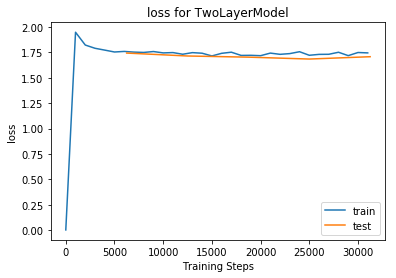

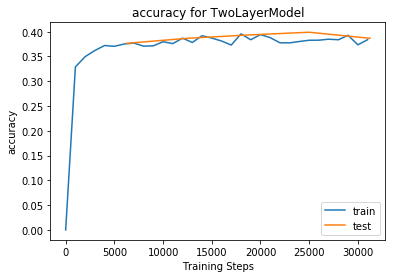

In [10]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [11]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3,3), stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Conv2d(16, 16, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            Flatten()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(4096, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

        
    def forward(self, x):
        x = self.layer1(x)
        #x = x.view(512, 64)
        x = self.layer2(x)
        return(x)


model = ConvModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004280, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.814721, Train Accuracy: 0.340000
  Epoch 0 @ step 2000: Train Loss: 1.579486, Train Accuracy: 0.424500
  Epoch 0 @ step 3000: Train Loss: 1.523278, Train Accuracy: 0.447625
  Epoch 0 @ step 4000: Train Loss: 1.469823, Train Accuracy: 0.463625
  Epoch 0 @ step 5000: Train Loss: 1.431902, Train Accuracy: 0.481125
  Epoch 0 @ step 6000: Train Loss: 1.392955, Train Accuracy: 0.503750
Epoch 0 Test Loss: 1.453382, Test Accuracy: 0.473600, time: 23.8s
  Epoch 1 @ step 7000: Train Loss: 1.395619, Train Accuracy: 0.489875
  Epoch 1 @ step 8000: Train Loss: 1.374484, Train Accuracy: 0.499000
  Epoch 1 @ step 9000: Train Loss: 1.377012, Train Accuracy: 0.507250
  Epoch 1 @ step 10000: Train Loss: 1.353213, Train Accuracy: 0.512000
  Epoch 1 @ step 11000: Train Loss: 1.340086, Train Accuracy: 0.514000
  Epoch 1 @ step 12000: Train Loss: 1.364718, Train Accuracy: 0.504375
Epoch 1 Test Loss: 1.392

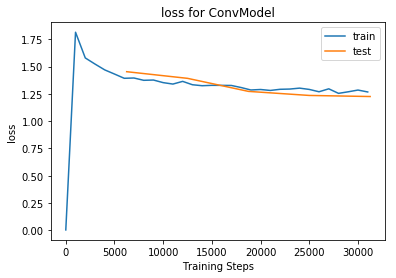

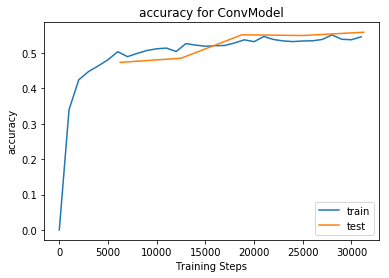

In [12]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1?

Yes, there is around 17% improvement due to the more complex network having convolution.

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import os
import sys
import time
import math
import numpy as np
import torch.nn.init as init


class Bottleneck(nn.Module):
    def __init__(self, last_planes, in_planes, out_planes, dense_depth, stride, first_layer):
        super(Bottleneck, self).__init__()
        self.out_planes = out_planes
        self.dense_depth = dense_depth

        self.conv1 = nn.Conv2d(last_planes, in_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=32, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv3 = nn.Conv2d(in_planes, out_planes+dense_depth, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes+dense_depth)

        self.shortcut = nn.Sequential()
        if first_layer:
            self.shortcut = nn.Sequential(
                nn.Conv2d(last_planes, out_planes+dense_depth, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes+dense_depth)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        x = self.shortcut(x)
        d = self.out_planes
        out = torch.cat([x[:,:d,:,:]+out[:,:d,:,:], x[:,d:,:,:], out[:,d:,:,:]], 1)
        out = F.relu(out)
        return out


class AwesomeModel(nn.Module):
    def __init__(self):
        super(AwesomeModel, self).__init__()
        in_planes= (96,192,384,768)
        out_planes = (256,512,1024,2048)
        num_blocks = (3,4,20,3)
        dense_depth = (16,32,24,128)

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.last_planes = 64
        self.layer1 = self._make_layer(in_planes[0], out_planes[0], num_blocks[0], dense_depth[0], stride=1)
        self.layer2 = self._make_layer(in_planes[1], out_planes[1], num_blocks[1], dense_depth[1], stride=2)
        self.layer3 = self._make_layer(in_planes[2], out_planes[2], num_blocks[2], dense_depth[2], stride=2)
        self.layer4 = self._make_layer(in_planes[3], out_planes[3], num_blocks[3], dense_depth[3], stride=2)
        self.linear = nn.Linear(out_planes[3]+(num_blocks[3]+1)*dense_depth[3], 10)

    def _make_layer(self, in_planes, out_planes, num_blocks, dense_depth, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i,stride in enumerate(strides):
            layers.append(Bottleneck(self.last_planes, in_planes, out_planes, dense_depth, stride, i==0))
            self.last_planes = out_planes + (i+2) * dense_depth
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model
print('==> Building model..')

model = AwesomeModel()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

if False:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    checkpoint = torch.load('./ckpt.t7')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

training_epochs = 35
metrics = train(model, trainloader, testloader, criterion, optimizer, training_epochs, start_epoch, False)
    

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
  Epoch 0 @ step 0: Train Loss: 0.004320, Train Accuracy: 0.000109
Epoch 0 Test Loss: 1.429393, Test Accuracy: 0.499502, time: 465.0s
  Epoch 1 @ step 1000: Train Loss: 1.561394, Train Accuracy: 0.433984
Epoch 1 Test Loss: 1.043824, Test Accuracy: 0.649084, time: 464.5s
  Epoch 2 @ step 2000: Train Loss: 0.957145, Train Accuracy: 0.662938
Epoch 2 Test Loss: 0.738590, Test Accuracy: 0.744825, time: 464.8s
  Epoch 3 @ step 3000: Train Loss: 0.694074, Train Accuracy: 0.757891
Epoch 3 Test Loss: 0.615264, Test Accuracy: 0.791501, time: 464.3s
Epoch 4 Test Loss: 0.551556, Test Accuracy: 0.813893, time: 464.3s
  Epoch 5 @ step 4000: Train Loss: 0.562092, Train Accuracy: 0.806359
Epoch 5 Test Loss: 0.512148, Test Accuracy: 0.827826, time: 464.5s
  Epoch 6 @ step 5000: Train Loss: 0.471191, Train Accuracy: 0.838641
Epoch 6 Test Loss: 0.482098, Test Accuracy: 0.835291, time: 465

**What changes did you make to improve your model?** 

Data Normalization, running for more Epochs(~140), pickeling(saving) the model every time the produces accuracy which is more than the current best result. Using Stochastic Gradient Descent as optimizer.
In terms of the network I added more layers, batch 2d normalization, and average pooling.

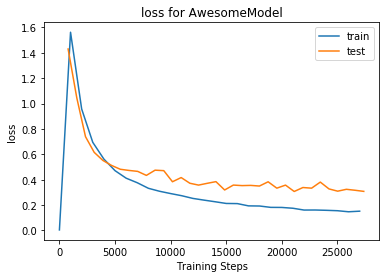

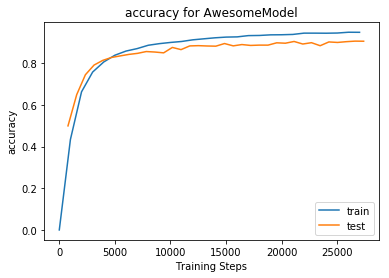

In [6]:
plot_graphs("AwesomeModel", metrics)

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [7]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

--2019-04-29 23:42:22--  http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Resolving courses.engr.illinois.edu (courses.engr.illinois.edu)... 130.126.151.9
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip [following]
--2019-04-29 23:42:22--  https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841776 (3.7M) [application/x-zip-compressed]
Saving to: ‘test_file.zip’

test_file.zip       100%[===================>]   3.66M  13.0MB/s    in 0.3s    

2019-04-29 23:42:23 (13.0 MB/s) - ‘test_file.zip’ saved [3841776/3841776]

Archive:  test_file.zip
  inflating: test_file.pt            


Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [8]:
import torch.utils.data as Data

test_file = './test_file.pt'
pred_file = './submission.txt'
f_pred = open(pred_file,'w') 
tensor = torch.load(test_file)

torch_dataset = Data.TensorDataset(tensor)  
test_loader = torch.utils.data.DataLoader(torch_dataset, 64, shuffle=False, num_workers=2)

for ele in test_loader:
    x = ele[0]
    for image in x:
      image = image.reshape((1, 3, 32, 32))
      image = image.to(device)
      prediction = model(image)
      _, predicted = torch.max(prediction, dim=1)
      predicted = predicted.tolist()[0]
      f_pred.write(str(predicted))
      f_pred.write('\n')
    
f_pred.close()
print('Done!')

Done!



# Report

## Part 0: Imports and Basic Setup (5 Points)
Nothing to report for this part. You will be just scored for finishing the setup.

## Part 1: Fully connected neural networks (25 Points)

Test (on validation set) accuracy (5 Points):0.393000

Test loss (5 Points):1.710990

Training time (5 Points):84.4s/epoch


Plots:

- For both accuracy and loss plots on validation set vs training steps please see above or:
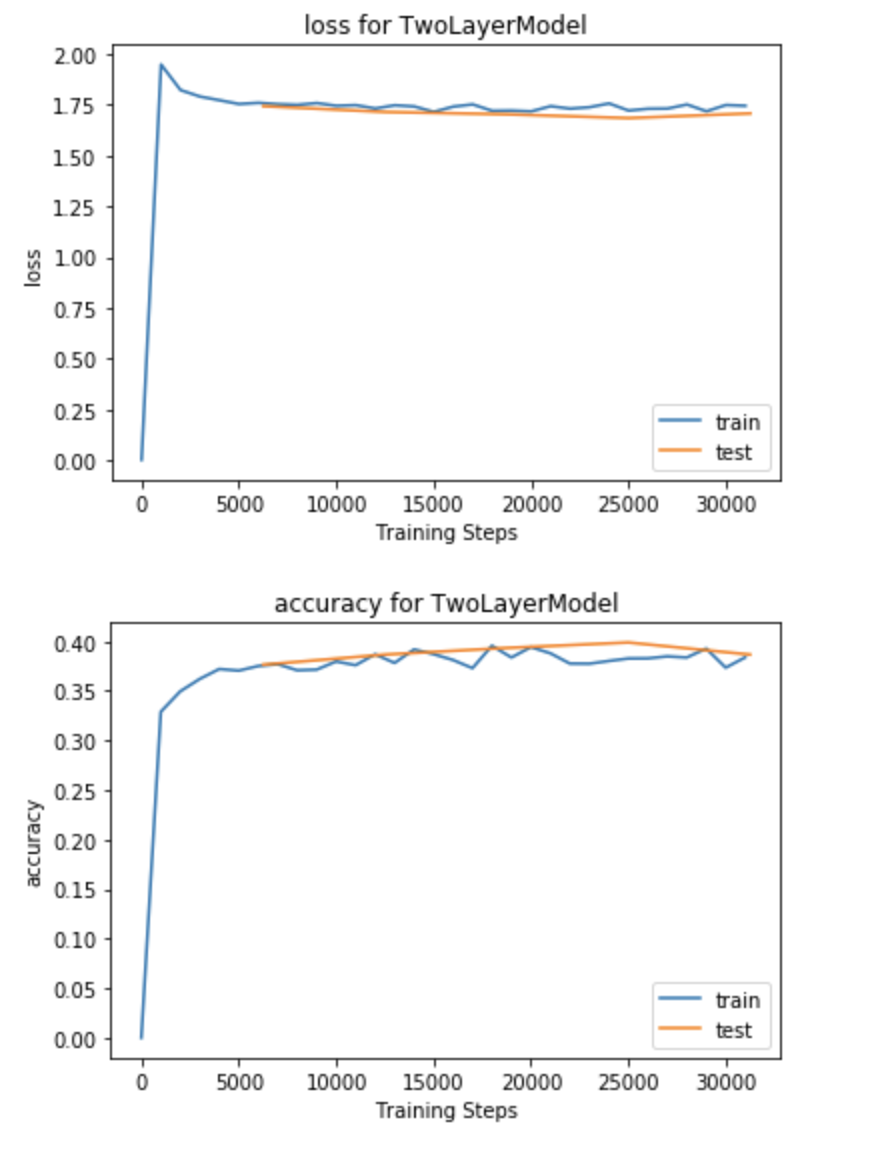


## Part 2: Convolution Network (Basic) (35 Points)

Tensor dimensions: A good way to debug your network for size mismatches is to print the dimension of output after every layers:

(10 Points)

Output dimension after 1st conv layer: tensor with size [8, 16, 32, 32]

Output dimension after 1st max pooling: tensor with size [8, 16, 16, 16]

Output dimension after 2nd conv layer: tensor with size [8, 16, 32, 32]

Output dimension after flatten layer: tensor with size [8, 4096]

Output dimension after 1st fully connected layer: [8, 64]

Output dimension after 2nd fully connected layer: [8, 10]


Test (on validation set) Accuracy (5 Points):0.544800

Test loss (5 Points):1.254007

Training time (5 Points):123.2s/epoch


Plots:

- For both accuracy and loss plots on validation set vs training steps please see above or:
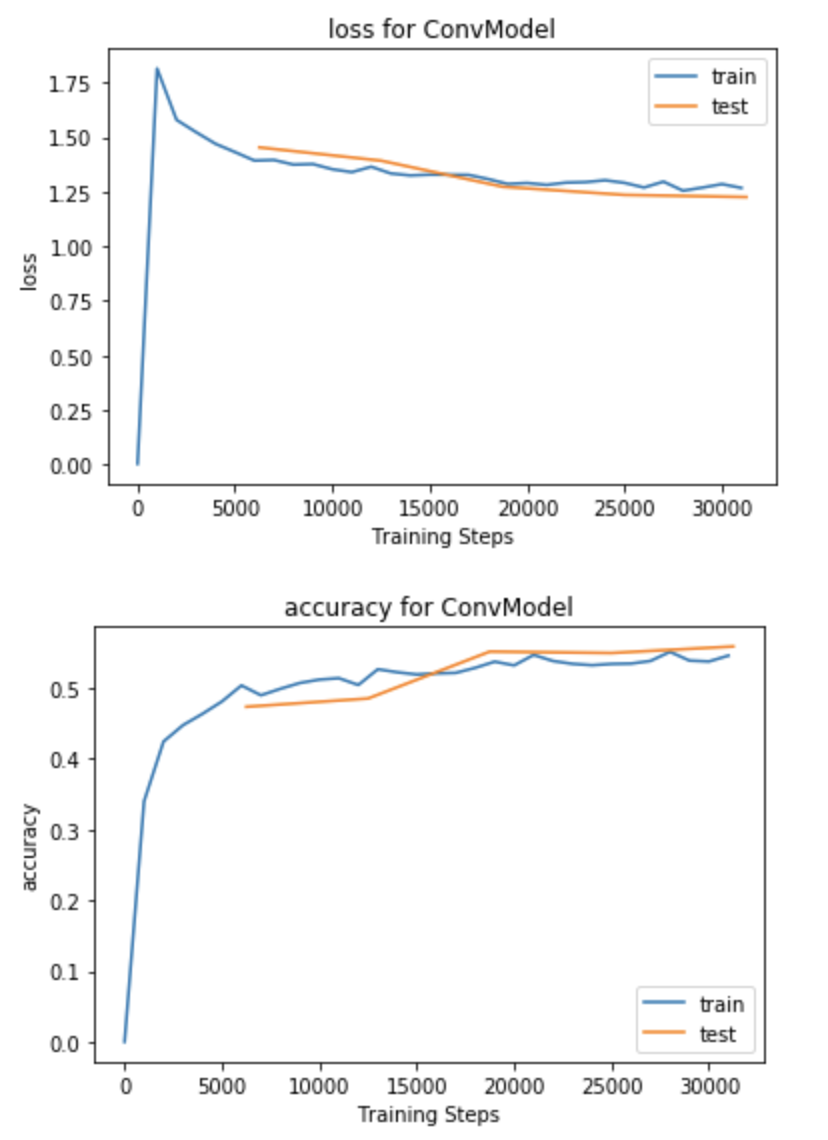



## Part 3: Convolution Network (Add one or more  suggested changes) (35 Points)

Describe the additional changes implemented, your intuition for as to why it works, you may also describe other approaches you experimented with (10 Points):


Test (on validation set) Accuracy (5 Points): 86.6%. Leader board name: yan

Test loss (5 Points):0.308

Training time (5 Points):463s/epoch Trained more than 140 epochs with model checkpoint saving.


Plots:


- For both accuracy and loss plots on validation set vs training steps please see above or:

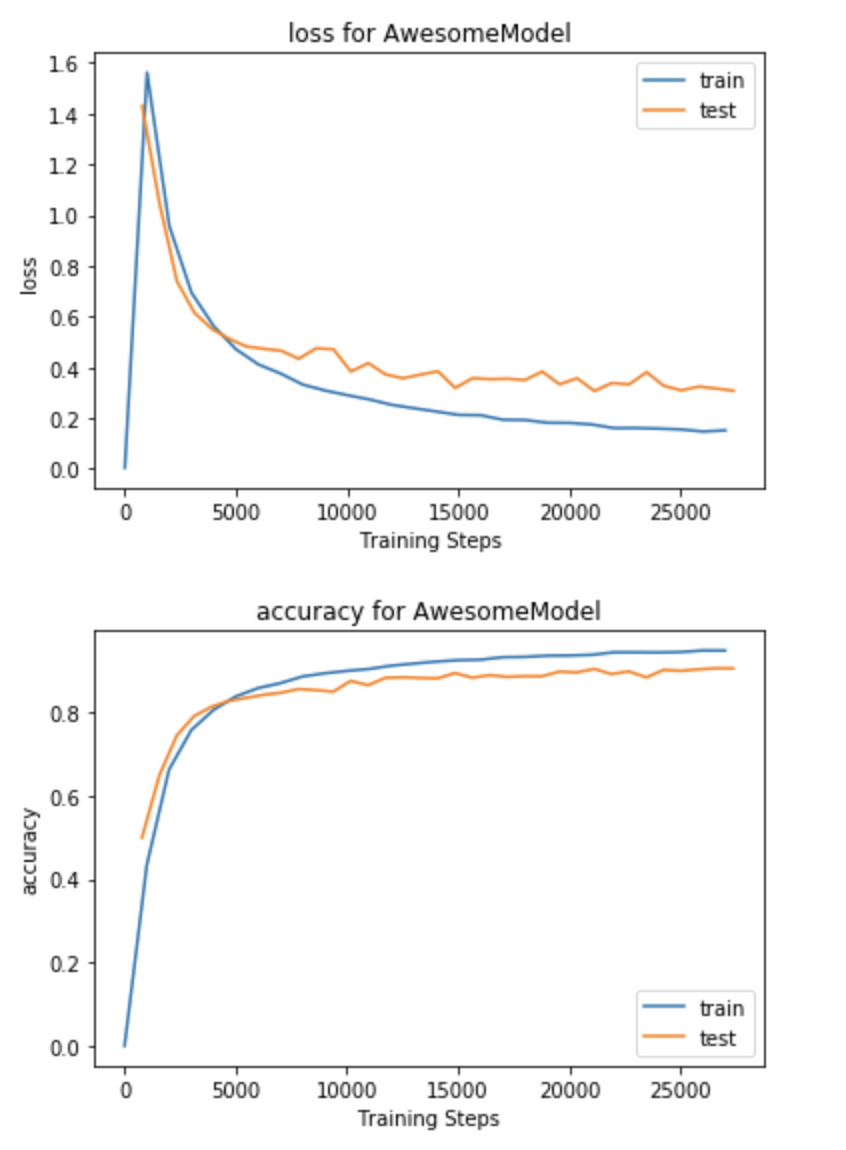

10 bonus points will be awarded to top 3 scorers on leaderboard (in case of tie for 3rd position everyone tied for 3rd position will get the bonus)

On the following screenshot you can see the training including checkpoint saving the model in t7 format. This helped a lot in case of Google Colab resets my session :)

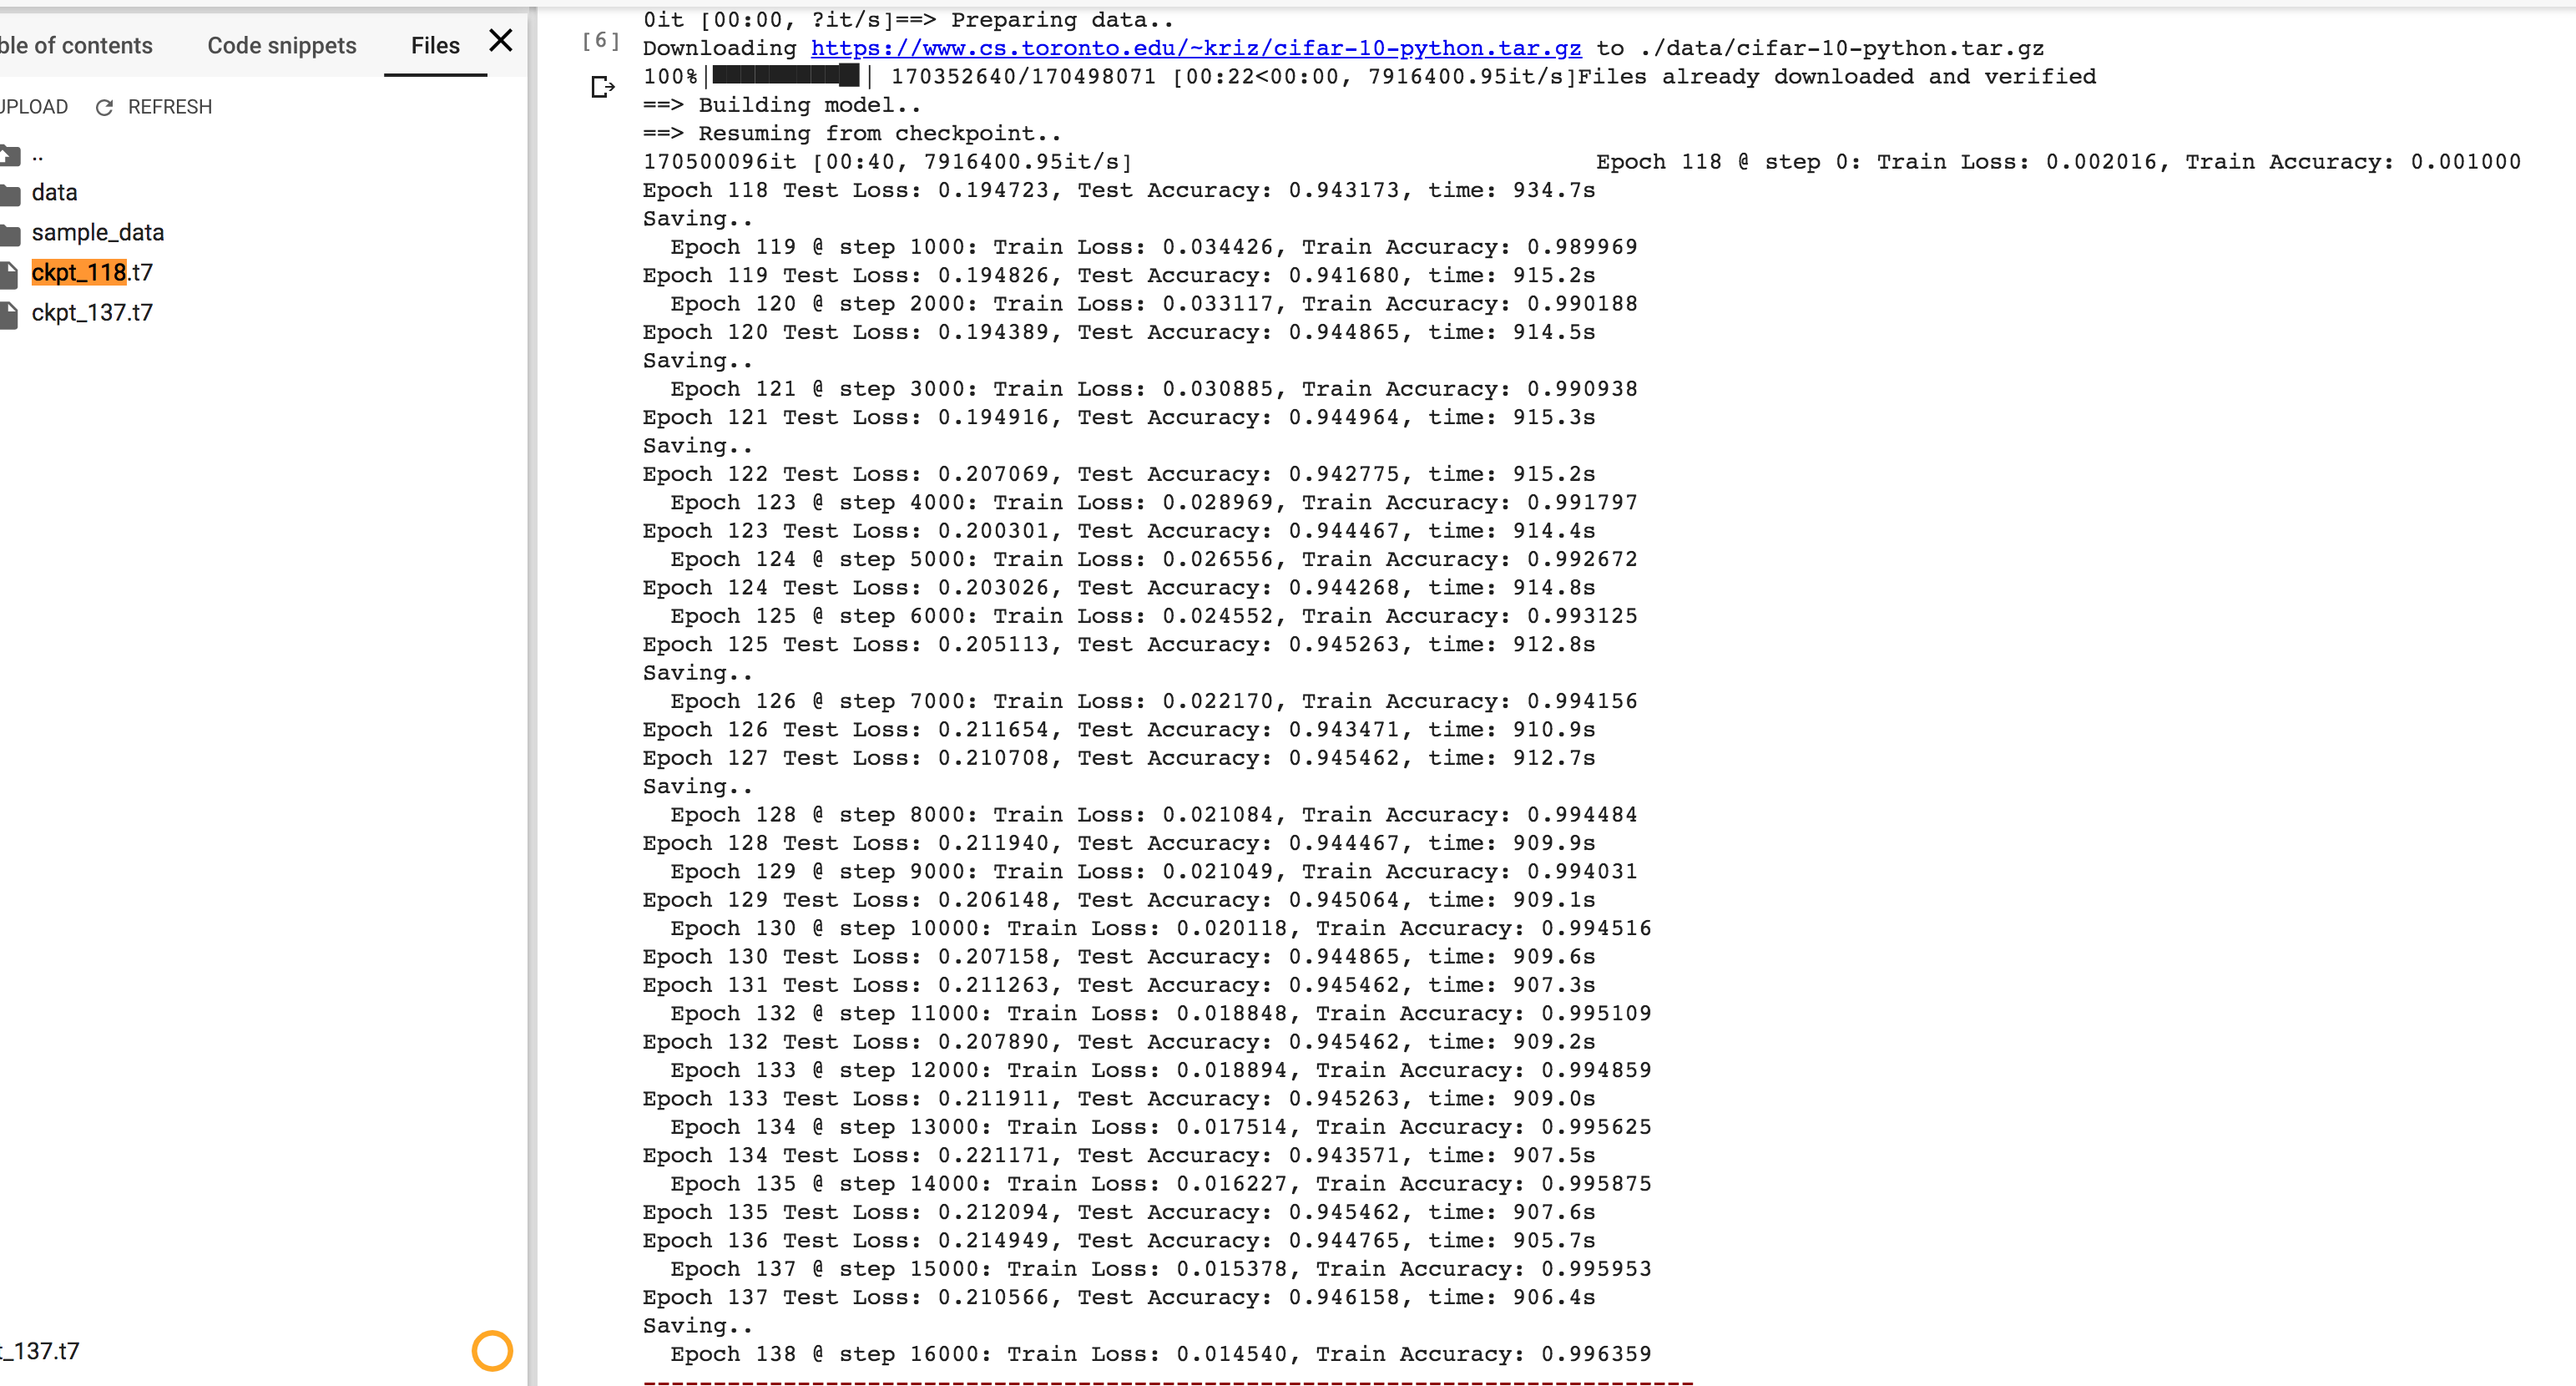